# Lab 1 - Fitting Probability Models
In this lab you will practice fitting the probability models that we have discussed in class. 

We would like to build a system that automatically detects which pixels belong to coins. We will discuss how to design discriminative and generative models to consider this task on. 

For now, focus on fitting the probability models to our data. 

We classify a pixel as a coin if:
$$
\operatorname{Pr}(c=1 | \vec{x})=\frac{\operatorname{Pr}(\vec{x} | c=1)}{\operatorname{Pr}(\vec{x} | c=0)+\operatorname{Pr}(\vec{x} | c=1)}>0.5
$$

REMEMBER THAT:
![Bayes](bayes.png)

Therefore, for each type of distribution we will have to train two models - one trained on all coin pixels, and one trained on all the desk pixels.

## Preprocessing & Features
* Write a function that reads in the image as well as the mask with `cv2`
* Convert the image into `HSV` with `cvtcolor`
* View the 6 different components of the image:
    * Blue
    * Green
    * Red
    * Hue
    * Saturation
    * Value
Done Below

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from mpmath import *
from tqdm import tqdm

In [2]:
def read_image(name):
    img = cv2.imread(name,-1)
    t = "BGR "+name
    plt.title(t)
    plt.imshow(img)
    plt.show()
    return img

def show_components(bgr,title):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    b = bgr[:,:,0]
    g = bgr[:,:,1]
    r = bgr[:,:,2]
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    components = [b,g,r,h,s,v]
    comps = ['Blue','Green','Red','Hue','Saturation','Value']
    fig=plt.figure(figsize=(8, 8))
    fig.suptitle(title)
    columns = 3
    rows = 2
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(components[i-1])
        plt.title(comps[i-1])
    plt.show()

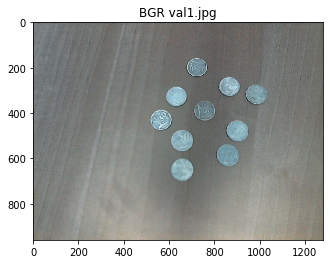

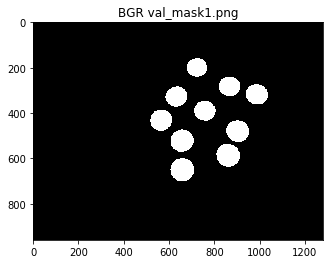

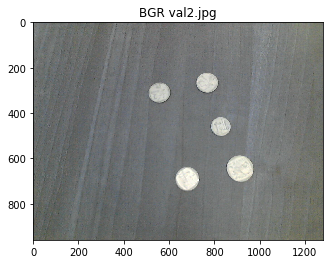

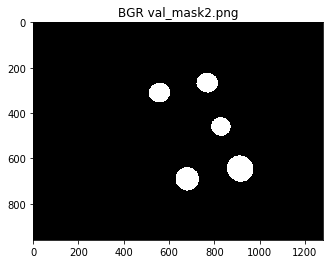

In [3]:
val1 = read_image("val1.jpg")
val1_m = read_image("val_mask1.png")
val2 = read_image("val2.jpg")
val2_m = read_image("val_mask2.png")

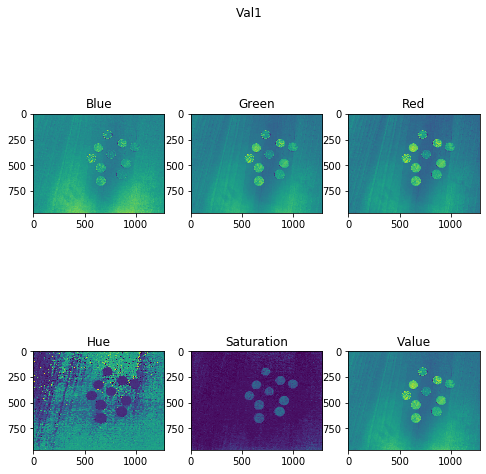

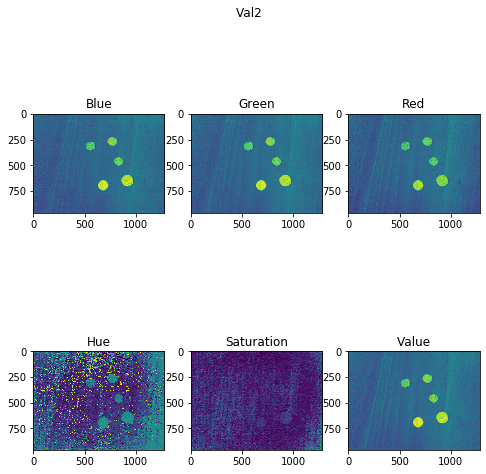

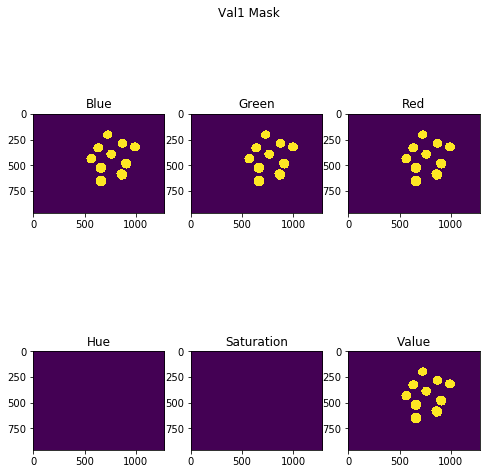

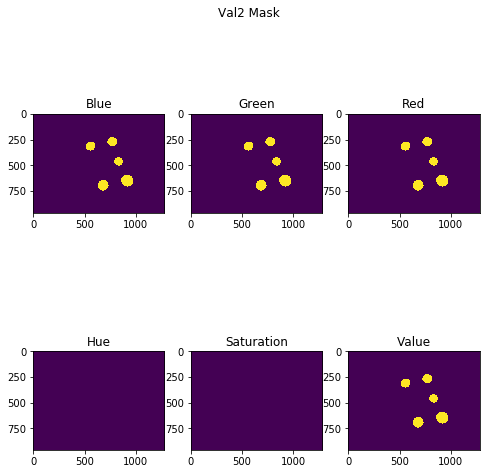

In [4]:
show_components(val1,"Val1")
show_components(val2,"Val2")
show_components(val1_m,"Val1 Mask")
show_components(val2_m,"Val2 Mask")

What do you notice about the appearance of the coins in each of the channels?
* They generally appear brighter then the rest of the image.

We need to decide on a feature set to represent our raw data. In this case we can use the raw pixel values or some combination thereof.

# 3 Fitting a Normal Distribution
We have covered a number of different distributions during lectures along with their conjugates. We also have a number of different ways of fitting data to these models, namely using *Maximum Likelihood*, *Maximum a Posteriori* and *Bayesian* approaches.

We are to fit a univariate normal distribution using each of the 3 methods and each of the 6 channels. You should then compare the accuracy of these method/feature pairs on both the training and validation images

Apply the model to every pixel in the image, display a white pixel when $
\operatorname{Pr}(c=1 | \vec{x})>0.5
$. Use these images to understand when the model performs well and when it performs badly

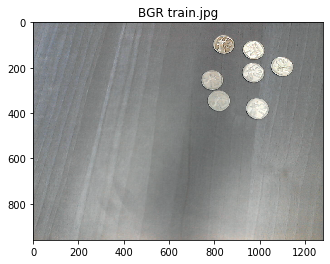

Coin pixels: 46255
Non-coin pixels: 1182545


In [5]:
train_bgr = read_image("train.jpg")
train_hsv = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2HSV)

train_mask = cv2.cvtColor(cv2.imread('mask.jpg'), cv2.COLOR_BGR2GRAY)
train_mask = np.where(train_mask > 245, 255, 0)

print('Coin pixels: {}'.format(np.sum(train_mask==255)))
print('Non-coin pixels: {}'.format(np.sum(train_mask==0)))

# Maximum Likelihood
Fitting: As the name suggests: we find the parameters under which the data $X_{1 ... I}$ is most likely:
$$
\begin{aligned} \hat{\boldsymbol{\theta}} &=\underset{\boldsymbol{\theta}}{\operatorname{argmax}}\left[\operatorname{Pr}\left(\mathbf{x}_{1 \ldots I} | \boldsymbol{\theta}\right)\right] \\ &=\underset{\boldsymbol{\theta}}{\operatorname{argmax}}\left[\prod_{i=1}^{I} \operatorname{Pr}\left(\mathbf{x}_{i} | \boldsymbol{\theta}\right)\right] \end{aligned}
$$

In this case, as we are working with a normal distribution the entire equation will be as follows:
$$
\begin{aligned} \operatorname{Pr}\left(x_{1 \ldots I} | \mu, \sigma^{2}\right) &=\prod_{i=1} \operatorname{Pr}\left(x_{i} | \mu, \sigma^{2}\right) \\ &=\prod_{i=1}^{I} \operatorname{Norm}_{x_{i}}\left[\mu, \sigma^{2}\right] \\ &=\frac{1}{\left(2 \pi \sigma^{2}\right)^{I / 2}} \exp \left[-0.5 \sum_{i=1}^{I} \frac{\left(x_{i}-\mu\right)^{2}}{\sigma^{2}}\right] \end{aligned}
$$

We can take the log in order to remove the complexity of using the product:
$$
\begin{aligned} \hat{\mu}, \hat{\sigma}^{2} &=\underset{\mu, \sigma^{2}}{\operatorname{argmax}}\left[\sum_{i=1}^{I} \log \left[\operatorname{Norm}_{x_{i}}\left[\mu, \sigma^{2}\right]\right]\right] \\ &=\underset{\mu, \sigma^{2}}{\operatorname{argmax}}\left[-0.5 I \log [2 \pi]-0.5 I \log \sigma^{2}-0.5 \sum_{i=1}^{I} \frac{\left(x_{i}-\mu\right)^{2}}{\sigma^{2}}\right] \end{aligned}
$$

This gives us the following:
$$
\begin{aligned} \hat{\mu} &=\frac{\sum_{i=1}^{I} x_{i}}{I} \\ \hat{\sigma}^{2} &=\sum_{i=1}^{I} \frac{\left(x_{i}-\hat{\mu}\right)^{2}}{I} \end{aligned}
$$

In [6]:
# Thus, based on above we can get the following mean and variance for ML
def ml_mean(x):
    return np.sum(x) / len(x)

def ml_var(x):
    mu = ml_mean(x)
    return np.sum((x - mu)**2) / len(x)

In [7]:
train_value_coin = train_hsv[:,:,2][ np.where(train_mask==255) ].ravel()
train_value_desk = train_hsv[:,:,2][ np.where(train_mask==0) ].ravel()

In [8]:
mu_coin = ml_mean(train_value_coin)
var_coin = ml_var(train_value_coin)
mu_desk = ml_mean(train_value_desk)
var_desk = ml_var(train_value_desk)

In [9]:
print('μ coin: {:.3f}'.format(mu_coin))
print('σ² coin: {:.3f}\n'.format(var_coin))
print('μ desk: {:.3f}'.format(mu_desk))
print('σ² desk: {:.3f}'.format(var_desk))

μ coin: 203.740
σ² coin: 1093.142

μ desk: 137.191
σ² desk: 338.366


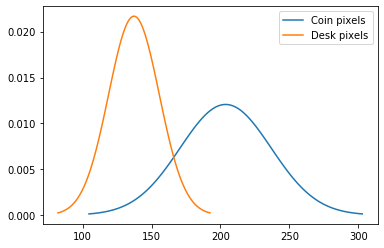

In [10]:
x = np.linspace(mu_coin - 3*np.sqrt(var_coin),mu_coin + 3*np.sqrt(var_coin), 100)
plt.plot(x, stats.norm.pdf(x, loc=mu_coin, scale=np.sqrt(var_coin)), label='Coin pixels')

x = np.linspace(mu_desk - 3*np.sqrt(var_desk),mu_desk + 3*np.sqrt(var_desk), 100)
plt.plot(x, stats.norm.pdf(x, loc=mu_desk, scale=np.sqrt(var_desk)), label='Desk pixels')

plt.legend();

Then we simply go through each pixel and pull the values for x out of our distributions - using Bayes rule in order to get the probability and check whether that value is $> 0.5$ or not

In [11]:
val_1 = cv2.cvtColor(cv2.imread('val1.jpg'), cv2.COLOR_BGR2HSV)[:,:,2] # value channel only
val_1_ml_pred = []
print(val_1.shape)
for x in tqdm(val_1.ravel()):
    p_coin = stats.norm.pdf(x, loc=mu_coin, scale=np.sqrt(var_coin)) # p(x|c=1)
    p_desk = stats.norm.pdf(x, loc=mu_desk, scale=np.sqrt(var_desk)) # p(x|c=0)
    p = p_coin / (p_coin + p_desk) # p(c=1|x)
    val_1_ml_pred.append(p > 0.5)
    
val_1_ml_pred = np.array(val_1_ml_pred).reshape(val_1.shape)

  0%|          | 1281/1228800 [00:00<03:11, 6406.32it/s]

(960, 1280)


100%|██████████| 1228800/1228800 [03:14<00:00, 6330.51it/s]


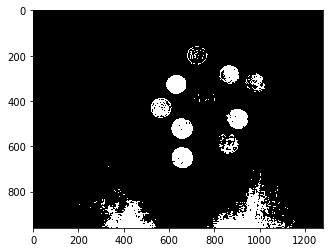

In [12]:
plt.imshow(val_1_ml_pred, cmap='gray');

# Maximum A Posteriori
We are now attempting to maximize the posterior probability. This time, after following the same steps outlined for ML we get the following equations:
$$
\hat{\mu}, \hat{\sigma}^{2}=\underset{\mu, \sigma^{2}}{\operatorname{argmax}}\left[\sum_{i=1}^{I} \log \left[\operatorname{Norm}_{x_{i}}\left[\mu, \sigma^{2}\right]\right]+\log \left[\operatorname{NormInvGam}_{\mu, \sigma^{2}}[\alpha, \beta, \gamma, \delta]\right]\right]
$$

This means, that our values are:
$$
\begin{array}{c}{\hat{\mu}=\frac{\sum_{i=1} x_{i}+\gamma \delta}{I+\gamma}} \\ {\hat{\sigma^{2}}=\frac{\sum_{i=1}^{I}\left(x_{i}-\mu\right)^{2}+2 \beta+\gamma(\delta-\mu)^{2}}{I+3+2 \alpha}}\end{array}
$$

In [13]:
def map_mean(x, γ, δ):
    return (np.sum(x) + γ*δ) / (len(x) + γ) 

def map_var(x, α, β, γ, δ):
    μ = map_mean(x, γ, δ)
    return (np.sum((x - μ)**2) + 2*β + γ*(δ - μ)**2 )  /  (len(x) + 3 + 2*α)

In [14]:
(α, β, γ, δ) = (1,1,1,1)

mu_coin = map_mean(train_value_coin, γ, δ)
var_coin = map_var(train_value_coin, α, β, γ, δ)
mu_desk = map_mean(train_value_desk, γ, δ)
var_desk = map_var(train_value_desk, α, β, γ, δ)

print('μ coin: {:.3f}'.format(mu_coin))
print('σ² coin: {:.3f}\n'.format(var_coin))
print('μ desk: {:.3f}'.format(mu_desk))
print('σ² desk: {:.3f}'.format(var_desk))

μ coin: 203.736
σ² coin: 1093.913

μ desk: 137.191
σ² desk: 338.381


In [15]:
val_1_map_pred = []

for x in tqdm(val_1.ravel()):
    p_coin = stats.norm.pdf(x, loc=mu_coin, scale=np.sqrt(var_coin)) # p(x|c=1)
    p_desk = stats.norm.pdf(x, loc=mu_desk, scale=np.sqrt(var_desk)) # p(x|c=0)
    p = p_coin / (p_coin + p_desk) # p(c=1|x)
    val_1_map_pred.append(p > 0.5)
    
val_1_map_pred = np.array(val_1_map_pred).reshape(val_1.shape)

100%|██████████| 1228800/1228800 [03:18<00:00, 6195.79it/s]


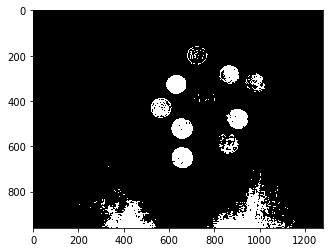

In [16]:
plt.imshow(val_1_map_pred, cmap='gray');

# Bayesian Approach

In [ ]:
def bayes_mean(x, γ, δ):
    return (np.sum(x) + γ*δ) / (len(x) + γ) 

def bayes_var(x, α, β, γ, δ):
    μ = map_mean(x, γ, δ)
    return (np.sum((x - μ)**2) + 2*β + γ*(δ - μ)**2 )  /  (len(x) + 3 + 2*α)

In [ ]:
val_1_bayes_pred = []
for x in tqdm(val_1.ravel()):
    

# 4 Learned Models
Fit the models and note the values below:

Number of coin and non-coin pixels:

|Type|Number|
|---|---|
|Coin Pixels||
|Non-Coin pixels||

Maximum Likelihood

|Pixels|$\mu_{coin}$|$\mu_{desk}$|Train Acc|Val Acc|$ Pr(c=1 \vec^{(1)}) $|$Pr(c=1 | \vec^{(2)})$|
|---|---|---|---|---|---|---|
|1 Pixel|||||||
|25%|||||||
|50%|||||||
|100%||||||